# House pricing investigation

In [3]:
# import the packages we need to investigate the data
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd

from calendar import monthrange
import matplotlib.dates as mdates
import scipy.stats as st
import requests
from meteostat import Point, Daily

import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', False)
seed= 92

In [4]:

# Read the CSV file into a DataFrame
train = pd.read_csv('train.csv')

print(train.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
train['Alley'].info()
train['Alley'].fillna('No Alley', inplace=True)

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Alley
Non-Null Count  Dtype 
--------------  ----- 
91 non-null     object
dtypes: object(1)
memory usage: 11.5+ KB


Text(0.5, 1.0, 'kde plot of train')

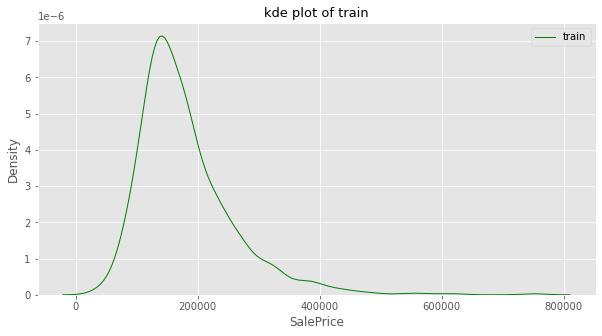

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = sns.kdeplot(data=train, x='SalePrice', color='green', label='train', linewidth= 1)
plt.legend()
ax.set_title('kde plot of train', fontsize=13)

We can see that some prices are outliers that can be removed to improve the accuracy of our data analysis.

Prices over 500000 can be removed.

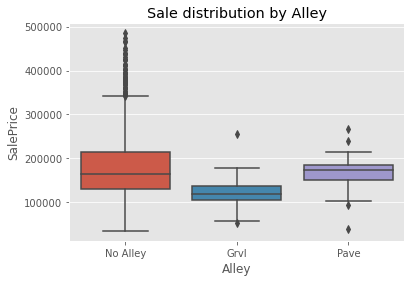

In [22]:
sns.boxplot(x='Alley', y='SalePrice', data=train[train['SalePrice']< 500000])
plt.title('Sale distribution by Alley')
plt.show()

In [23]:
train[train['Alley']=='Grvl']['SalePrice'].mean()


122219.08

In [24]:
train[train['Alley']=='Pave']['SalePrice'].mean()


168000.58536585365

In [25]:
train[train['Alley']=='No Alley']['SalePrice'].mean()

183452.13148283417

It can be concluded that the prices of houses with Gravel are significantly lower than paved houses or no alley houses

In [13]:
train['SalePrice'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePrice
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB
